# Carga de datos y librerias

In [ ]:
# Cargar datos desde Google Drive
from google.colab import drive
from google.colab import auth
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from oauth2client.client import GoogleCredentials

### 1. En la línea de código 12 la variable
downloaded = drive.CreateFile({'id': 'PONER EL ID DEL ENLACE DEL ARCHIVO DE GOOGLE DRIVE'})

### 2. lo que va después del 'id': entre comillas simples, es el código que da el archivo al pedir enlace para compartir --> copiar vínculo --> dejar los permisos de acceso general en cualquier usuario que tenga el vínculo --> dejar acceso a lector.

### 3. el copiar el vínculo se debe dejar la línea solo lo que se encuentra entre `d/` y el `/view`
### Ej. https://drive.google.com/file/d/1Xn5POKCUa-rgbxytj6eZCc7AlqkJTiwh/view?usp=sharing - Tomar solamente `1Xn5POKCUa-rgbxytj6eZCc7AlqkJTiwh`       


In [ ]:
# 1. Autenticación y creación del cliente PyDrive.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Referencia de PyDrive:
# https://gsuitedevs.github.io/PyDrive/docs/build/html/index.html

# Método para importar el archivo desde Google Drive
# Descarga el archivo de Google Drive
downloaded = drive.CreateFile({'id': '1kbzCy0a9Q-_Ty3uuEfC3ep2j8k5pG47Z'})
# Lo guarda en la variable contenido
contenido = downloaded.GetContentString()
# Imprime el tamaño en Bytes del archivo compartido
print("Descargados {} bytes".format(len(contenido)))

Descargados 3577592424 bytes


In [ ]:
# Opción alternativa para guardar el archivo localmente
downloaded.GetContentFile('DataSet.csv')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#Parte 1

El conjunto de datos inicial consta de 29.704.090 transacciones ejecutadas por 400 clientes finales que compran y venden valores específicos en un mercado específico. Sin embargo, con el propósito de hacer la tercera entrega más flexible, se selecciona una muestra de 3 millones de transacciones del conjunto de datos original.

Los campos clave contenidos en los datos incluyen:

1. **Transaction ID:** Identificación única de la transacción.

2. **Originator:** El origen de la transacción.

3. **Originator_ID:** Identificación del originador.

4. **EntryDate:** Fecha y hora de entrada de la transacción.

5. **InputOutput:** Indica si la transacción es una entrada o salida.

6. **Market:** Mercado en el que se realizó la transacción.

7. **Product ISIN:** Identificador ISIN del producto.

8. **Product Type:** Tipo de producto (por ejemplo, acciones al contado, acciones futuras, bono).

9. **Product Class:** Clase del producto (por ejemplo, acciones, renta fija).

10. **Normalized Amount:** Monto normalizado de la transacción.

11. **Currency:** Moneda en la que se realizó la transacción.

12. **Anomaly:** Indica si hay alguna anomalía en la transacción.

In [ ]:
df=pd.read_csv('DataSet.csv',nrows=3000000)
df.head()

,Transaction ID,Originator,Originator_ID,EntryDate,InputOutput,Market,Product ISIN,Product Type,Product Class,Normalized Amount,Currency,Anomaly
0,I9Q3S5YYLCQX,Client_087,_XID,2019-01-01 17:55:33,Sell,Market2,ISN-X01-LRBXBXN,FutureCommodity,Trade,10317357.93,Currency1,0
1,VFZ6INAXVYJV,Client_019,_XID,2019-01-01 18:52:34,Sell,Market1,ISN-X01-856Z8OC,FX,Trade,31042.04,Currency2,0
2,HXOA8DNPX1OE,Client_385,_XID,2019-01-01 15:21:09,Sell,Market1,ISN-X01-5CW2HUF,SimpleTransfer,Trade,35910.53,Currency1,0
3,O9W5IR932XT1,Client_276,_XID,2019-01-01 20:02:36,Sell,Market1,ISN-X01-AQ848H7,FutureEquity,Trade,79630.92,Currency2,0
4,84KF31TPK1LU,Client_049,_XID,2019-01-01 09:06:58,Buy,Market1,ISN-X01-7JWB2C7,FX,Trade,434370.69,Currency1,0


In [ ]:
df['Product Type'].unique()

array(['FutureCommodity', 'FX', 'SimpleTransfer', 'FutureEquity',
       'FutureOptionEquityIndex', 'FXForward', 'FutureBond', 'ADR',
       'FutureEquityIndex', 'Bond', 'CAADR', 'Repo', 'Equity', 'FutureFX',
       'FXSwap', 'ETOEquity', 'ETOEquityIndex'], dtype=object)

In [ ]:
df['Product Class'].unique()

array(['Trade', 'ADR Conversion',
       'Cash in / out (withdrawal), Security in / out', 'External fee'],
      dtype=object)

In [ ]:
df['EntryDate'] = pd.to_datetime(df['EntryDate'])
df['Weekday'] = df['EntryDate'].dt.weekday
df['Hour'] = df['EntryDate'].dt.hour

df['Morning'] = df['Hour'].apply(lambda x: 1 if 6 <= x < 12 else 0)  # Mañana (6:00 - 11:59)
df['Evening'] = df['Hour'].apply(lambda x: 1 if 12 <= x < 18 else 0)  # Tarde (12:00 - 17:59)
df['Night'] = df['Hour'].apply(lambda x: 1 if 18 <= x < 24 or 0 <= x < 6 else 0)  # Noche (18:00 - 23:59), (00:00 - 5:59)

condition_round_amount = ((df['Normalized Amount'].apply(lambda x: str(x).count('000.0')) >= 1) & (df['Normalized Amount'] == df['Normalized Amount'].round()))
df['Round_Amount_Condition'] = condition_round_amount.astype(int)

condition_small_amount = ((df['Normalized Amount']<1139.34) & (df['Normalized Amount']>420.65))
df['Small_Amount_Condition'] = condition_small_amount

condition_amount_sell = df['InputOutput'] == 'Sell'
df['Amount_Sell_Condition'] = condition_amount_sell
condition_amount_buy = df['InputOutput'] == 'Buy'
df['Amount_Buy_Condition'] = condition_amount_buy
inoutdelta=(df['InputOutput'] == 'Buy').astype(int) - (df['InputOutput'] == 'Sell').astype(int)
df['InputOutput_Delta']=inoutdelta

aggregated_df = df.groupby(['Originator', 'Weekday', 'Hour', 'Morning', 'Evening', 'Night']).agg(
    num_transactions=('Transaction ID', 'count'),
    total_amount_traded=('Normalized Amount', 'sum'),
    anomaly=('Anomaly', 'max'),
    transactions_count_small_amount=('Small_Amount_Condition', 'sum'),
    transactions_count_round_amount=('Round_Amount_Condition', 'sum'),
    transactions_count_amount_sell=('Amount_Sell_Condition', 'sum'),
    transactions_count_amount_buy=('Amount_Buy_Condition', 'sum'),
    inputoutput_delta=('InputOutput_Delta', 'sum')
).reset_index()

df.drop(columns=['Round_Amount_Condition'], inplace=True)
df.drop(columns=['Small_Amount_Condition'], inplace=True)
df.drop(columns=['Amount_Sell_Condition'], inplace=True)
df.drop(columns=['Amount_Buy_Condition'], inplace=True)
df.drop(columns=['InputOutput_Delta'], inplace=True)

print(aggregated_df)

       Originator  Weekday  Hour  Morning  Evening  Night  num_transactions  \
0      Client_001        0     1        0        0      1                 1   
1      Client_001        0     3        0        0      1                 2   
2      Client_001        0     5        0        0      1                 2   
3      Client_001        0     6        1        0      0                 2   
4      Client_001        0     7        1        0      0                37   
...           ...      ...   ...      ...      ...    ...               ...   
40480  Client_400        4    17        0        1      0                61   
40481  Client_400        4    18        0        0      1                55   
40482  Client_400        4    19        0        0      1                52   
40483  Client_400        4    20        0        0      1                30   
40484  Client_400        4    22        0        0      1                 1   

       total_amount_traded  anomaly  transactions_c

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 17 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Transaction ID     object        
 1   Originator         object        
 2   Originator_ID      object        
 3   EntryDate          datetime64[ns]
 4   InputOutput        object        
 5   Market             object        
 6   Product ISIN       object        
 7   Product Type       object        
 8   Product Class      object        
 9   Normalized Amount  float64       
 10  Currency           object        
 11  Anomaly            int64         
 12  Weekday            int32         
 13  Hour               int32         
 14  Morning            int64         
 15  Evening            int64         
 16  Night              int64         
dtypes: datetime64[ns](1), float64(1), int32(2), int64(4), object(9)
memory usage: 366.2+ MB


In [ ]:
df['Originator'].nunique() #400 clientes

400

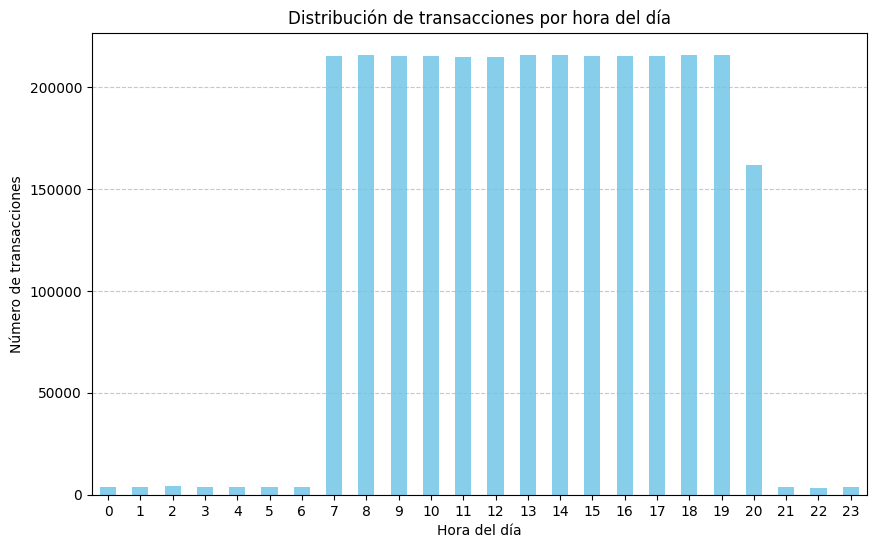

In [ ]:
hourly_distribution = aggregated_df.groupby('Hour')['num_transactions'].sum()
plt.figure(figsize=(10, 6))
hourly_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribución de transacciones por hora del día')
plt.xlabel('Hora del día')
plt.ylabel('Número de transacciones')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

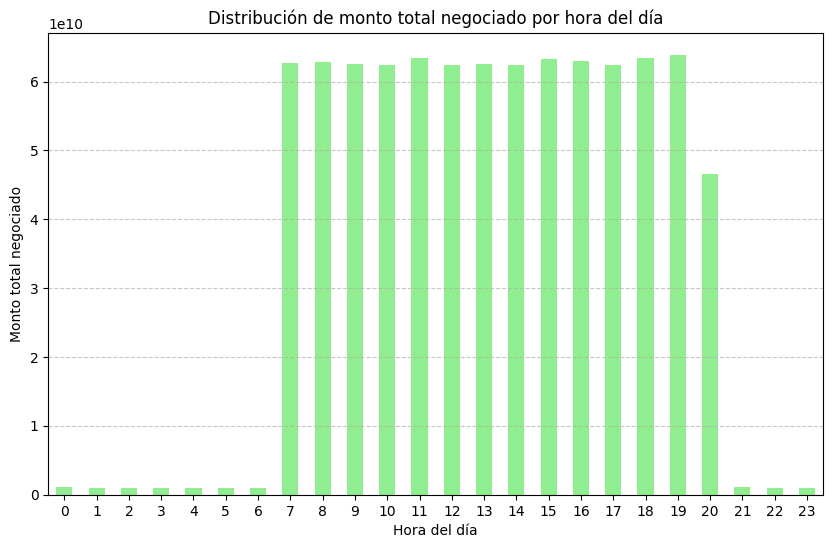

In [ ]:
hourly_amount_distribution = aggregated_df.groupby('Hour')['total_amount_traded'].sum()
plt.figure(figsize=(10, 6))
hourly_amount_distribution.plot(kind='bar', color='lightgreen')
plt.title('Distribución de monto total negociado por hora del día')
plt.xlabel('Hora del día')
plt.ylabel('Monto total negociado')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

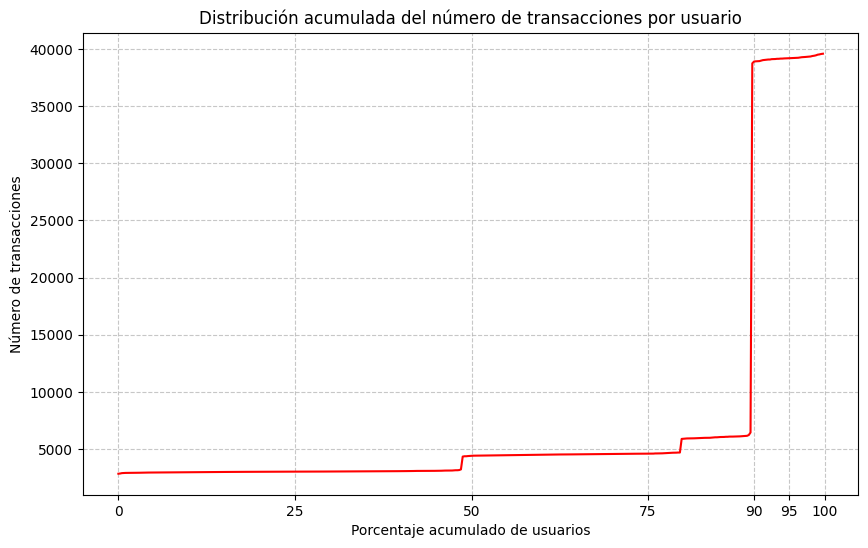

Percentiles de transacciones por usuario:
Percentil 25: 3025.75 transacciones
Percentil 50: 4408.5 transacciones
Percentil 75: 4598.25 transacciones
Percentil 90: 38767.9 transacciones
Percentil 95: 39196.25 transacciones


In [ ]:
transactions_per_user = aggregated_df.groupby('Originator')['num_transactions'].sum()
transactions_per_user_sorted = transactions_per_user.sort_values(ascending=False)


percentiles = [25, 50, 75, 90, 95]
percentile_values = transactions_per_user_sorted.quantile([p / 100 for p in percentiles])

cumulative_percentage = (1 - transactions_per_user_sorted.rank(method='first', ascending=False) / len(transactions_per_user_sorted)) * 100

plt.figure(figsize=(10, 6))
plt.plot(cumulative_percentage, transactions_per_user_sorted.values, color='red')
plt.title('Distribución acumulada del número de transacciones por usuario')
plt.xlabel('Porcentaje acumulado de usuarios')
plt.ylabel('Número de transacciones')
plt.xticks([0, 25, 50, 75, 90, 95, 100], [0, 25, 50, 75, 90, 95, 100])
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

print("Percentiles de transacciones por usuario:")
for p, value in zip(percentiles, percentile_values):
    print(f"Percentil {p}: {value} transacciones")

In [ ]:
top_clients = transactions_per_user_sorted[transactions_per_user_sorted > 5000]
sum_top_clients = top_clients.count()
sum_top_clientst = top_clients.sum()
total_transactions = aggregated_df['num_transactions'].sum()

low_clients = transactions_per_user_sorted[transactions_per_user_sorted < 5000]
sum_low_clients = low_clients.count()
sum_low_clientst = low_clients.sum()
total_transactions = aggregated_df['num_transactions'].sum()

percentage_top_clients = (sum_top_clientst / total_transactions) * 100
print(sum_top_clients,' clientes ejecutaron el ',percentage_top_clients, '% de las transacciones o', sum_top_clientst)

percentage_low_clients = (sum_low_clientst / total_transactions) * 100
print(sum_low_clients,' clientes ejecutaron el ',percentage_low_clients, '% de las transacciones o', sum_low_clientst)

81  clientes ejecutaron el  61.626333333333335 % de las transacciones o 1848790
319  clientes ejecutaron el  38.373666666666665 % de las transacciones o 1151210


In [ ]:
percentage_below_1M = (df[df['Normalized Amount'] < 1000000].shape[0] / df.shape[0]) * 100

percentage_below_10K = (df[df['Normalized Amount'] < 10000].shape[0] / df.shape[0]) * 100

print(f"El {percentage_below_1M:.2f}% de las transacciones tienen un monto menor a 1M USD, y el {percentage_below_10K:.2f}% de ellas tienen un monto menor a 10K USD.")

El 96.02% de las transacciones tienen un monto menor a 1M USD, y el 26.19% de ellas tienen un monto menor a 10K USD.


1. Este dataset consta de transacciones ejecutadas por 400 clientes finales que compran y venden valores específicos en un mercado determinado. Los datos cubren 60 días divididos en 12 semanas (una semana se compone de 5 días). No se incluyen sábados ni domingos debido al cierre de los mercados durante el fin de semana.

2. Las transacciones se distribuyen uniformemente entre las 12 semanas, y la mayoría de ellas se ejecutan durante el horario de apertura del mercado, mientras que solo un pequeño porcentaje se ejecuta durante las primeras horas de la mañana y al final del día.

3. Alrededor del 90% de los usuarios realizaron al menos 5000 transacciones, mientras que el 10% de los usuarios realizó alrededor de 25000, lo que significa que el 10% de los clientes ejecutaron casi el 50% de las transacciones.

4. El 96.02% de las transacciones tienen un monto menor a 1M USD, y el 26.20% de ellas tienen un monto menor a 10K USD.



***Tipos de Anomalias***

El conjunto de datos está extremadamente desbalanceado en términos de transacciones anómalas, representando solo el 0.2542% o menos del 1% del total de transacciones. Este desbalance se establece para replicar escenarios del mundo real, donde las anomalías son eventos raros y poco comunes.

Se generaron cinco clases de anomalías basadas en ejemplos de patrones sospechosos sugeridos por el GAFI, un organismo intergubernamental que promueve la implementación efectiva de medidas legales, regulatorias y operativas para combatir el lavado de dinero.


In [ ]:
df_filtered = df[df['Anomaly'] != 0]
anomaly_counts = df_filtered['Anomaly'].value_counts()

sum(anomaly_counts/df.shape[0])*100

0.25483333333333336

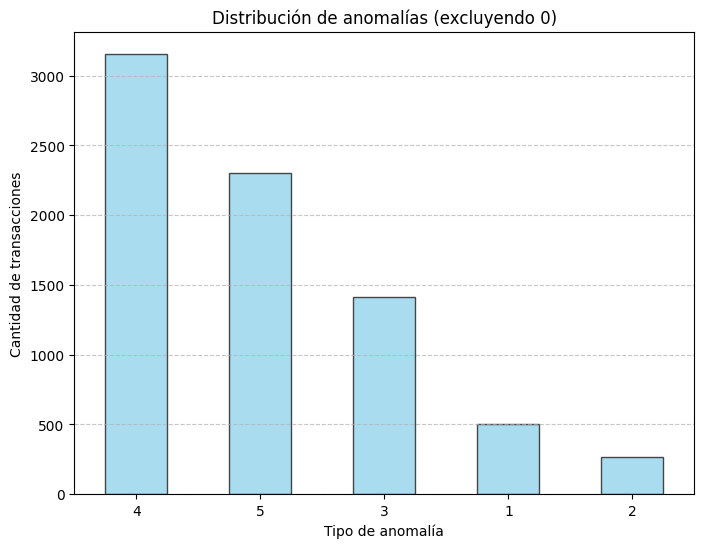

In [ ]:
df_filtered = df[df['Anomaly'] != 0]
anomaly_counts = df_filtered['Anomaly'].value_counts()

plt.figure(figsize=(8, 6))
anomaly_counts.plot(kind='bar', color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribución de anomalías (excluyendo 0)')
plt.xlabel('Tipo de anomalía')
plt.ylabel('Cantidad de transacciones')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

1. **Transacciones pequeñas pero muy frecuentes generadas en un corto período de tiempo:** Este patrón incluye múltiples transacciones por debajo de los umbrales establecidos, pero que ocurren con una alta frecuencia en un corto lapso.

2. **Transacciones con montos normalizados redondeados comprados o vendidos dentro de una cuenta:** Es inusual que las transacciones en los mercados de capitales tengan montos redondeados. Este patrón implica la presencia de montos de transacción que son sospechosamente redondeados.

3. **Valor comprado o vendido en un momento inusual:** Normalmente, los clientes negocian valores específicos dentro de un período de tiempo definido. Este patrón se refiere a transacciones que ocurren en momentos inusuales.

4. **Gran retiro/transacción de dinero:** Este patrón implica un aumento repentino en el monto de la transacción retirado de una cuenta o transferido, que se desvía de lo normal.

5. **Una cantidad inusualmente grande de activos transferidos dentro y fuera de una cuenta en un corto período de tiempo:** Este patrón implica la transferencia de una gran cantidad de activos dentro y fuera de una cuenta en un corto lapso, lo cual es inusual y puede indicar actividades sospechosas.

#Parte 2

In [ ]:
print('Duplicados dataset original: ', df.duplicated().sum())
print('--------------------------------------')
print('Nulos dataset original:')
print(df.isnull().sum())

Duplicados dataset original:  0
--------------------------------------
Nulos dataset original:
Transaction ID       0
Originator           0
Originator_ID        0
EntryDate            0
InputOutput          0
Market               0
Product ISIN         0
Product Type         0
Product Class        0
Normalized Amount    0
Currency             0
Anomaly              0
Weekday              0
Hour                 0
Morning              0
Evening              0
Night                0
dtype: int64


In [ ]:
aggregated_df

,Originator,Weekday,Hour,Morning,Evening,Night,num_transactions,total_amount_traded,anomaly,transactions_count_small_amount,transactions_count_round_amount,transactions_count_amount_sell,transactions_count_amount_buy,inputoutput_delta
0,Client_001,0,1,0,0,1,1,1361820.02,0,0,0,1,0,-1
1,Client_001,0,3,0,0,1,2,95285.55,0,0,0,1,1,0
2,Client_001,0,5,0,0,1,2,804627.20,0,0,0,0,2,2
3,Client_001,0,6,1,0,0,2,91003.97,0,0,0,1,1,0
4,Client_001,0,7,1,0,0,37,17289776.19,0,6,0,19,18,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40480,Client_400,4,17,0,1,0,61,22388467.64,0,11,0,32,29,-3
40481,Client_400,4,18,0,0,1,55,14950084.73,0,9,0,27,28,1
40482,Client_400,4,19,0,0,1,52,15391233.35,0,8,0,26,26,0
40483,Client_400,4,20,0,0,1,30,17412891.91,0,8,0,15,15,0


In [ ]:
print("Duplicados:")
print(aggregated_df.duplicated().sum())

print("\nValores nulos por columna:")
print(aggregated_df.isnull().sum())

print("\nStrings vacíos por columna:")
for column in aggregated_df.select_dtypes(include=['object']).columns:
    print(f"{column}: {(df[column] == '').sum()}")

print("\nNúmero de valores únicos por columna:")
for column in aggregated_df.select_dtypes(include=['object']).columns:
    print(f"{column}: {aggregated_df[column].nunique()}")

Duplicados:
0

Valores nulos por columna:
Originator                         0
Weekday                            0
Hour                               0
Morning                            0
Evening                            0
Night                              0
num_transactions                   0
total_amount_traded                0
anomaly                            0
transactions_count_small_amount    0
transactions_count_round_amount    0
transactions_count_amount_sell     0
transactions_count_amount_buy      0
inputoutput_delta                  0
dtype: int64

Strings vacíos por columna:
Originator: 0

Número de valores únicos por columna:
Originator: 400


In [ ]:
# identificación de outliers
if aggregated_df['num_transactions'].dropna().size > 0:
    q1 = aggregated_df['num_transactions'].quantile(0.25)
    q3 = aggregated_df['num_transactions'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    print("\nPosibles outliers en 'num_transactions':")
    print(aggregated_df['num_transactions'][(aggregated_df['num_transactions'] < lower_bound) | (aggregated_df['num_transactions'] > upper_bound)])


Posibles outliers en 'num_transactions':
855      506
856      530
857      518
858      536
859      513
        ... 
27878    163
27879    160
27880    152
28696    160
39277    158
Name: num_transactions, Length: 3016, dtype: int64


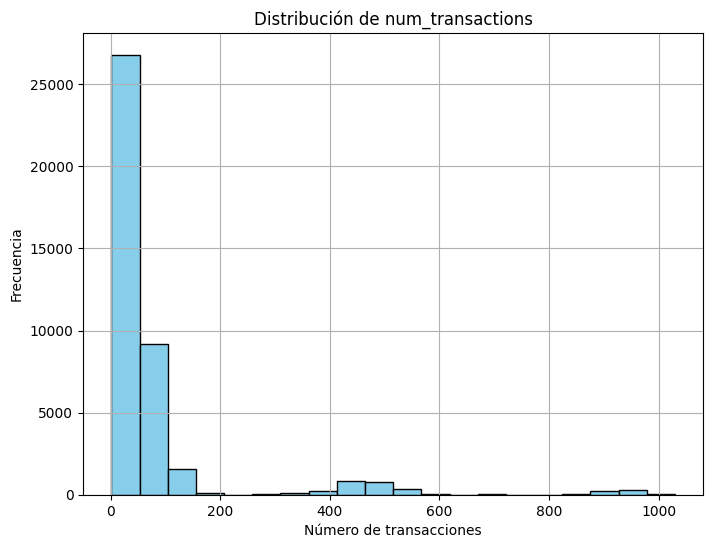

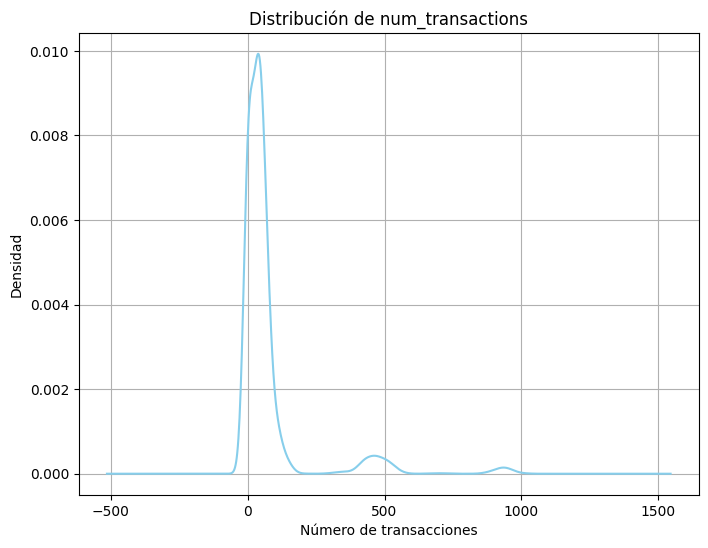

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(aggregated_df['num_transactions'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribución de num_transactions')
plt.xlabel('Número de transacciones')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
aggregated_df['num_transactions'].plot(kind='density', color='skyblue')
plt.title('Distribución de num_transactions')
plt.xlabel('Número de transacciones')
plt.ylabel('Densidad')
plt.grid(True)
plt.show()


In [ ]:
if aggregated_df['total_amount_traded'].dropna().size > 0:
    q1 = aggregated_df['total_amount_traded'].quantile(0.25)
    q3 = aggregated_df['total_amount_traded'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    print("\nPosibles outliers en 'num_transactions':")
    print(aggregated_df['total_amount_traded'][(aggregated_df['total_amount_traded'] < lower_bound) | (aggregated_df['total_amount_traded'] > upper_bound)])


Posibles outliers en 'num_transactions':
31       8.683317e+07
315      5.940338e+07
501      5.467178e+07
583      5.322588e+07
855      1.663110e+08
             ...     
40000    5.653603e+07
40051    5.714331e+07
40110    6.256839e+07
40215    7.104922e+07
40322    5.591281e+07
Name: total_amount_traded, Length: 3495, dtype: float64


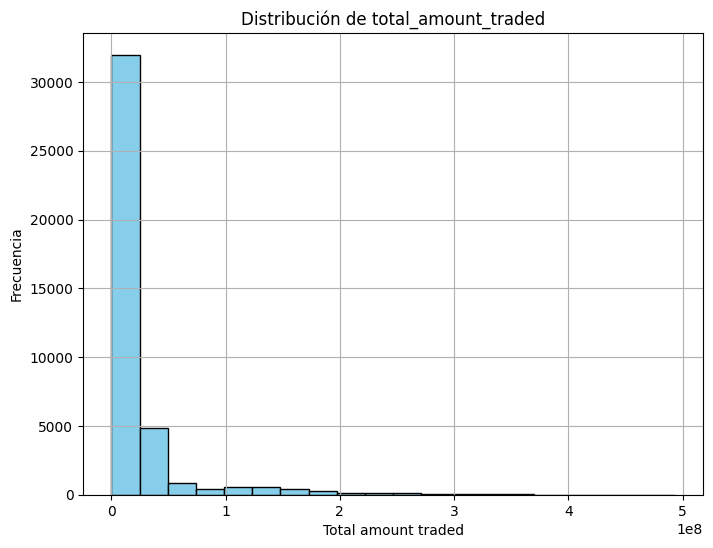

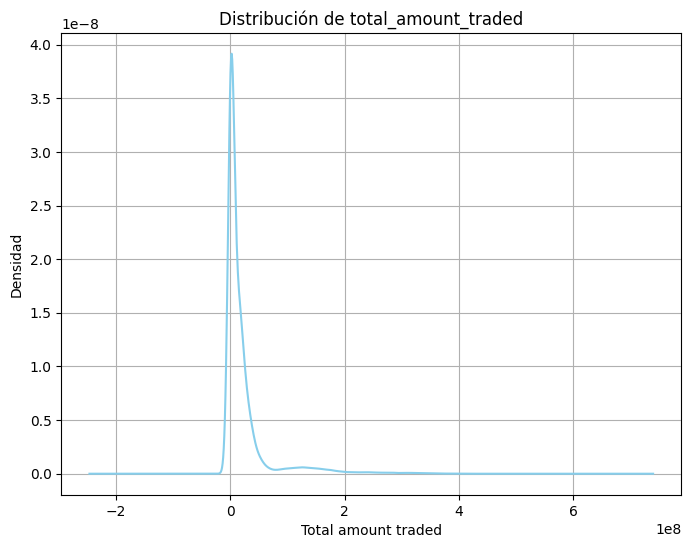

In [ ]:
import matplotlib.pyplot as plt

# Histograma
plt.figure(figsize=(8, 6))
plt.hist(aggregated_df['total_amount_traded'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribución de total_amount_traded')
plt.xlabel('Total amount traded')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# Gráfico de densidad
plt.figure(figsize=(8, 6))
aggregated_df['total_amount_traded'].plot(kind='density', color='skyblue')
plt.title('Distribución de total_amount_traded')
plt.xlabel('Total amount traded')
plt.ylabel('Densidad')
plt.grid(True)
plt.show()


-El conjunto de datos no posee valores duplicados ni valores nulos.

-No es posible identificar distribuciones estadísticas en los datos.

-Se identificaron, según la metodología de la desviación estándar utilizando el rango intercuartílico, posibles outliers en las columnas del dataset agregado. Sin embargo, debido a las características de las transacciones anómalas, se decidió no imputarlos.

In [ ]:
aggregated_df = pd.get_dummies(aggregated_df, columns=['Originator'])

In [ ]:
aggregated_df

,Weekday,Hour,Morning,Evening,Night,num_transactions,total_amount_traded,anomaly,transactions_count_small_amount,transactions_count_round_amount,...,Originator_Client_391,Originator_Client_392,Originator_Client_393,Originator_Client_394,Originator_Client_395,Originator_Client_396,Originator_Client_397,Originator_Client_398,Originator_Client_399,Originator_Client_400
0,0,1,0,0,1,1,1361820.02,0,0,0,...,False,False,False,False,False,False,False,False,False,False
1,0,3,0,0,1,2,95285.55,0,0,0,...,False,False,False,False,False,False,False,False,False,False
2,0,5,0,0,1,2,804627.20,0,0,0,...,False,False,False,False,False,False,False,False,False,False
3,0,6,1,0,0,2,91003.97,0,0,0,...,False,False,False,False,False,False,False,False,False,False
4,0,7,1,0,0,37,17289776.19,0,6,0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40480,4,17,0,1,0,61,22388467.64,0,11,0,...,False,False,False,False,False,False,False,False,False,True
40481,4,18,0,0,1,55,14950084.73,0,9,0,...,False,False,False,False,False,False,False,False,False,True
40482,4,19,0,0,1,52,15391233.35,0,8,0,...,False,False,False,False,False,False,False,False,False,True
40483,4,20,0,0,1,30,17412891.91,0,8,0,...,False,False,False,False,False,False,False,False,False,True


**Finalmente, se agregaron variables dummy para la columna Originator.** El resultado es un dataset agregado por cliente con 413 columnas.

Las agregaciones y transformaciones del dataset inicial se realizaron con el fin de capturar mejor las anomalías de acuerdo a cada una de las 5 anomalías descritas por la fuente de los datos, además del comportamiento específico de cada cliente.

La ventana de tiempo que se utilizó para agregar las transacciones es 'horas', aunque también podría haberse usado ventanas más amplias como días y semanas para capturar anomalías de largo plazo.

Agregar transacciones durante un período de tiempo es útil en el caso de uso de modelos AML, ya que se puede utilizar para capturar correlaciones a lo largo del tiempo entre múltiples transacciones.

#Parte 3

In [ ]:
X = aggregated_df.drop('anomaly', axis=1)  # características
y = aggregated_df['anomaly']  # variable objetivo

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_resampled_train, y_resampled_train = smote.fit_resample(X_train, y_train)

Se definieron tanto las características (X) como la variable objetivo (y) (anomalías).

Luego, se dividió el conjunto de datos en un conjunto de entrenamiento (X_train, y_train) y un conjunto de prueba (X_test, y_test), utilizando la función train_test_split, con un tamaño de prueba del 20% y una semilla aleatoria de 42.

Después, se aplicó la técnica de sobre muestreo SMOTE al conjunto de entrenamiento para abordar el desbalance de clases extremo. Esto se realizó mediante la creación de nuevas muestras sintéticas de la clase minoritaria (anomalías) para equilibrar la distribución de clases en el conjunto de entrenamiento.

#Parte 4: Hallazgos y Patrones

Dado que la fuente de datos no proporcionó algunos datos importantes para la construcción del conjunto de datos final agregado (aggregated_df), como:

1. El umbral de redondeo del monto de una transacción para considerarla anómala.
2. El umbral a partir del cual una transacción se considera pequeña.
3. El momento del día en que una transacción se considera sospechosa, entre otros.

Fue necesario:

1. Observar directamente las características de cada anomalía filtrando el conjunto de datos original (1, 2, 3, 4, 5).
2. Construir una matriz de confusión utilizando el modelo de Random Forest y realizar una actividad de ensayo y error para mejorar la precisión.

Precisión del modelo de Random Forest después de balancear los datos: 0.9956774113869334


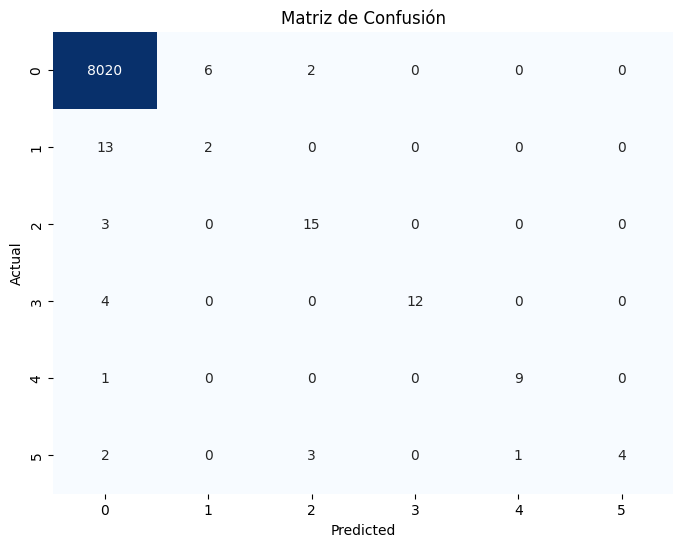

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_resampled_train, y_resampled_train)
y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo de Random Forest después de balancear los datos:", accuracy)

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**EL DESBALANCEO EXTREMO DE LOS DATOS SIGUE SIENDO UN PROBLEMA AUN EN LOS DATOS DE PRUEBA**

***ANOMALIA 1***

In [ ]:
anomalia=1 ###  Pequeñas y frecuentes transacciones en menos de una hora.
df[df['Anomaly']==anomalia].sample(10)

,Transaction ID,Originator,Originator_ID,EntryDate,InputOutput,Market,Product ISIN,Product Type,Product Class,Normalized Amount,Currency,Anomaly,Weekday,Hour,Morning,Evening,Night
2244745,AAUF1UI4RLN6,Client_378,_XID,2019-01-07 07:45:08,Sell,Market1,ISN-X01-BV4UZZ4,SimpleTransfer,"Cash in / out (withdrawal), Security in / out",819.91,Currency1,1,0,7,1,0,0
1108474,DZP6GOWA8JWQ,Client_066,_XID,2019-01-03 07:27:57,Sell,Market1,ISN-X01-AZAKIE0,SimpleTransfer,"Cash in / out (withdrawal), Security in / out",679.05,Currency1,1,3,7,1,0,0
2895878,XAM54UY38PFH,Client_066,_XID,2019-01-08 08:52:32,Sell,Market1,ISN-X01-CLNT86V,SimpleTransfer,"Cash in / out (withdrawal), Security in / out",813.05,Currency1,1,1,8,1,0,0
560444,ZQMN2ZHPTFX9,Client_212,_XID,2019-01-01 09:03:57,Buy,Market1,ISN-X01-9JS0DY3,SimpleTransfer,"Cash in / out (withdrawal), Security in / out",985.32,Currency2,1,1,9,1,0,0
921811,4ECRAY0QI554,Client_066,_XID,2019-01-02 17:09:22,Buy,Market1,ISN-X01-A4EHVJE,SimpleTransfer,"Cash in / out (withdrawal), Security in / out",928.24,Currency1,1,2,17,0,1,0
1344704,NHJKYJH7OSKB,Client_215,_XID,2019-01-03 09:42:36,Buy,Market1,ISN-X01-LA7KR18,SimpleTransfer,"Cash in / out (withdrawal), Security in / out",869.33,Currency2,1,3,9,1,0,0
1670691,FPIF7YDKCGBZ,Client_212,_XID,2019-01-04 14:05:45,Sell,Market1,ISN-X01-4NDWX54,SimpleTransfer,"Cash in / out (withdrawal), Security in / out",793.68,Currency1,1,4,14,0,1,0
2891745,3CWIZ6K2M8YE,Client_126,_XID,2019-01-08 14:00:54,Buy,Market1,ISN-X01-V7V4POK,SimpleTransfer,"Cash in / out (withdrawal), Security in / out",601.28,Currency2,1,1,14,0,1,0
2476858,3AO6FXSIB6YZ,Client_066,_XID,2019-01-07 10:34:06,Sell,Market1,ISN-X01-TRUTUK5,SimpleTransfer,"Cash in / out (withdrawal), Security in / out",877.58,Currency1,1,0,10,1,0,0
2305018,9UGYYO8CDU6E,Client_066,_XID,2019-01-07 22:48:49,Buy,Market1,ISN-X01-S2BS5X1,SimpleTransfer,"Cash in / out (withdrawal), Security in / out",631.31,Currency2,1,0,22,0,0,1


In [ ]:
anomalia=1 ### Pequeñas y frecuentes transacciones en menos de una hora.
df_y_test_diferentes_de_cero = pd.DataFrame({'y_test': y_test})
df_y_test_diferentes_de_cero = df_y_test_diferentes_de_cero[df_y_test_diferentes_de_cero['y_test'] != 0]
indices_filtrados = df_y_test_diferentes_de_cero.index
aggregated_df_filtrado = aggregated_df.loc[indices_filtrados]
resultados_anomalia = aggregated_df[aggregated_df.index.isin(aggregated_df_filtrado.index) & (aggregated_df['anomaly'] == anomalia)]
resultados_anomalia.head(20)

,Weekday,Hour,Morning,Evening,Night,num_transactions,total_amount_traded,anomaly,transactions_count_small_amount,transactions_count_round_amount,...,Originator_Client_391,Originator_Client_392,Originator_Client_393,Originator_Client_394,Originator_Client_395,Originator_Client_396,Originator_Client_397,Originator_Client_398,Originator_Client_399,Originator_Client_400
7250,3,7,1,0,0,34,22554813.37,1,4,0,...,False,False,False,False,False,False,False,False,False,False
12946,0,10,1,0,0,37,3039882.61,1,7,0,...,False,False,False,False,False,False,False,False,False,False
12969,1,11,1,0,0,72,17503183.78,1,12,0,...,False,False,False,False,False,False,False,False,False,False
13000,2,20,0,0,1,39,38742996.27,1,5,0,...,False,False,False,False,False,False,False,False,False,False
13033,4,11,1,0,0,32,1809143.22,1,6,0,...,False,False,False,False,False,False,False,False,False,False
13035,4,13,0,1,0,35,3290429.70,1,6,0,...,False,False,False,False,False,False,False,False,False,False
13040,4,18,0,0,1,38,5737849.56,1,13,0,...,False,False,False,False,False,False,False,False,False,False
21186,2,9,1,0,0,45,4591048.72,1,11,0,...,False,False,False,False,False,False,False,False,False,False
21191,2,14,0,1,0,34,20217870.58,1,7,0,...,False,False,False,False,False,False,False,False,False,False
21215,3,17,0,1,0,33,3206658.85,1,6,0,...,False,False,False,False,False,False,False,False,False,False


**La mayoría de las transacciones tienen montos menores a 1,000. Sin embargo, posiblemente debido a que la anomalía también considera la cantidad de transacciones (si son frecuentes), no se está logrando una buena precisión para la clase 1. Esto se debe a que se está trabajando con un total de 3 millones de transacciones, mientras que el dataset original consta de 29 millones.**

***ANOMALIA 2***

In [ ]:
anomalia=2 ###  Montos redondeados.
df[df['Anomaly']==anomalia].sample(10)

,Transaction ID,Originator,Originator_ID,EntryDate,InputOutput,Market,Product ISIN,Product Type,Product Class,Normalized Amount,Currency,Anomaly,Weekday,Hour,Morning,Evening,Night
679076,D29Z0AI9G7GG,Client_316,_XID,2019-01-02 11:26:15,Sell,Market2,ISN-X01-0J9DGB9,SimpleTransfer,"Cash in / out (withdrawal), Security in / out",11000.0,Currency1,2,2,11,1,0,0
1784132,L0DMSUD2GYPK,Client_389,_XID,2019-01-04 13:25:16,Sell,Market1,ISN-X01-ETUNMGJ,SimpleTransfer,"Cash in / out (withdrawal), Security in / out",12000.0,Currency1,2,4,13,0,1,0
2632823,9M93VTHEE7JC,Client_241,_XID,2019-01-08 11:13:56,Sell,Market1,ISN-X01-P8TJJJ9,SimpleTransfer,"Cash in / out (withdrawal), Security in / out",10000.0,Currency1,2,1,11,1,0,0
346960,2TQILJKOVZMH,Client_066,_XID,2019-01-01 07:44:04,Sell,Market2,ISN-X01-H3GW0VY,SimpleTransfer,"Cash in / out (withdrawal), Security in / out",11000.0,Currency1,2,1,7,1,0,0
1473245,GUJNW2HGB0O6,Client_212,_XID,2019-01-03 18:26:43,Sell,Market2,ISN-X01-05HU8P0,SimpleTransfer,"Cash in / out (withdrawal), Security in / out",10000.0,Currency1,2,3,18,0,0,1
201330,91L9UE8I1QAD,Client_066,_XID,2019-01-01 15:39:15,Sell,Market4,ISN-X01-E3NTUII,SimpleTransfer,"Cash in / out (withdrawal), Security in / out",11000.0,Currency2,2,1,15,0,1,0
179797,SQTQMPPDURI8,Client_066,_XID,2019-01-01 07:17:30,Sell,Market2,ISN-X01-8WY19KL,SimpleTransfer,"Cash in / out (withdrawal), Security in / out",12000.0,Currency2,2,1,7,1,0,0
2961175,L3OVVCRNWCFI,Client_066,_XID,2019-01-08 07:53:34,Sell,Market1,ISN-X01-0DWVG0F,SimpleTransfer,"Cash in / out (withdrawal), Security in / out",11000.0,Currency2,2,1,7,1,0,0
2982462,YLEL5SMZ98XO,Client_066,_XID,2019-01-08 15:34:38,Sell,Market1,ISN-X01-PO7C8UT,SimpleTransfer,"Cash in / out (withdrawal), Security in / out",10000.0,Currency1,2,1,15,0,1,0
201331,BHKVJWVWS82K,Client_066,_XID,2019-01-01 15:10:02,Sell,Market2,ISN-X01-AA2W9VL,SimpleTransfer,"Cash in / out (withdrawal), Security in / out",13000.0,Currency1,2,1,15,0,1,0


In [ ]:
anomalia=2 ### Montos redondeados.
df_y_test_diferentes_de_cero = pd.DataFrame({'y_test': y_test})
df_y_test_diferentes_de_cero = df_y_test_diferentes_de_cero[df_y_test_diferentes_de_cero['y_test'] != 0]
indices_filtrados = df_y_test_diferentes_de_cero.index
aggregated_df_filtrado = aggregated_df.loc[indices_filtrados]
resultados_anomalia = aggregated_df[aggregated_df.index.isin(aggregated_df_filtrado.index) & (aggregated_df['anomaly'] == anomalia)]
resultados_anomalia.head(20)

,Weekday,Hour,Morning,Evening,Night,num_transactions,total_amount_traded,anomaly,transactions_count_small_amount,transactions_count_round_amount,...,Originator_Client_391,Originator_Client_392,Originator_Client_393,Originator_Client_394,Originator_Client_395,Originator_Client_396,Originator_Client_397,Originator_Client_398,Originator_Client_399,Originator_Client_400
5078,1,7,1,0,0,882,3.038599e+08,2,224,3,...,False,False,False,False,False,False,False,False,False,False
7201,0,20,0,0,1,32,1.844122e+07,2,4,5,...,False,False,False,False,False,False,False,False,False,False
7212,1,10,1,0,0,85,5.250071e+07,2,21,8,...,False,False,False,False,False,False,False,False,False,False
7270,4,7,1,0,0,45,1.877168e+06,2,14,2,...,False,False,False,False,False,False,False,False,False,False
7277,4,14,0,1,0,42,3.163701e+06,2,10,1,...,False,False,False,False,False,False,False,False,False,False
12955,0,19,0,0,1,46,2.083071e+07,2,6,3,...,False,False,False,False,False,False,False,False,False,False
13039,4,17,0,1,0,43,1.367663e+07,2,14,1,...,False,False,False,False,False,False,False,False,False,False
17176,1,17,0,1,0,77,4.181633e+06,2,18,3,...,False,False,False,False,False,False,False,False,False,False
21171,1,15,0,1,0,71,3.829250e+07,2,14,1,...,False,False,False,False,False,False,False,False,False,False
21197,2,20,0,0,1,43,1.649562e+07,2,8,2,...,False,False,False,False,False,False,False,False,False,False


**Las transacciones que poseen montos redondeados (dos ceros después del punto decimal) son consideradas anómalas. La precisión de la clase 2 es buena.**

***ANOMALIA 3***

In [ ]:
anomalia=3 ###  Tiempo Inusual.
df[df['Anomaly']==anomalia].sample(10)

,Transaction ID,Originator,Originator_ID,EntryDate,InputOutput,Market,Product ISIN,Product Type,Product Class,Normalized Amount,Currency,Anomaly,Weekday,Hour,Morning,Evening,Night
1939282,PCQWDJ4SFD5H,Client_170,_XID,2019-01-04 02:03:35,Sell,Market2,ISN-X01-OJAVMAX,SimpleTransfer,"Cash in / out (withdrawal), Security in / out",38394.05,Currency1,3,4,2,0,0,1
417010,F5X7K0R88YUQ,Client_066,_XID,2019-01-01 04:06:59,Sell,Market1,ISN-X01-V0FQVU5,SimpleTransfer,"Cash in / out (withdrawal), Security in / out",52568.75,Currency2,3,1,4,0,0,1
819051,VYFTVJ7444LV,Client_066,_XID,2019-01-02 03:56:12,Sell,Market2,ISN-X01-WI9BRIF,SimpleTransfer,"Cash in / out (withdrawal), Security in / out",45275.38,Currency2,3,2,3,0,0,1
254955,SD29YUHR7D4Y,Client_212,_XID,2019-01-01 02:23:08,Sell,Market2,ISN-X01-Q0Q5F5G,SimpleTransfer,"Cash in / out (withdrawal), Security in / out",34050.61,Currency2,3,1,2,0,0,1
348103,9GJ9XWXEL75Q,Client_066,_XID,2019-01-01 04:16:58,Sell,Market2,ISN-X01-YODT5TK,SimpleTransfer,"Cash in / out (withdrawal), Security in / out",53272.16,Currency1,3,1,4,0,0,1
611721,S89Z0LGPNEJA,Client_066,_XID,2019-01-02 03:48:12,Sell,Market3,ISN-X01-T6FL63N,SimpleTransfer,"Cash in / out (withdrawal), Security in / out",37084.47,Currency1,3,2,3,0,0,1
2213006,V4XU5GSSVWTB,Client_212,_XID,2019-01-07 04:15:36,Sell,Market1,ISN-X01-QT9KSIZ,SimpleTransfer,"Cash in / out (withdrawal), Security in / out",39847.87,Currency1,3,0,4,0,0,1
17212,JKW58RXKCWS1,Client_316,_XID,2019-01-01 02:06:12,Sell,Market1,ISN-X01-QRE1CI5,SimpleTransfer,"Cash in / out (withdrawal), Security in / out",42961.60,Currency1,3,1,2,0,0,1
2060363,ABX3DB3W5SC6,Client_147,_XID,2019-01-07 02:10:22,Sell,Market1,ISN-X01-QX2268N,SimpleTransfer,"Cash in / out (withdrawal), Security in / out",36407.23,Currency1,3,0,2,0,0,1
1594294,5PZWRZPW6PW3,Client_147,_XID,2019-01-04 03:48:21,Sell,Market1,ISN-X01-INCC12X,SimpleTransfer,"Cash in / out (withdrawal), Security in / out",48774.45,Currency1,3,4,3,0,0,1


In [ ]:
anomalia=3 ### Tiempo Inusual.
df_y_test_diferentes_de_cero = pd.DataFrame({'y_test': y_test})
df_y_test_diferentes_de_cero = df_y_test_diferentes_de_cero[df_y_test_diferentes_de_cero['y_test'] != 0]
indices_filtrados = df_y_test_diferentes_de_cero.index
aggregated_df_filtrado = aggregated_df.loc[indices_filtrados]
resultados_anomalia = aggregated_df[aggregated_df.index.isin(aggregated_df_filtrado.index) & (aggregated_df['anomaly'] == anomalia)]
resultados_anomalia.head(20)

,Weekday,Hour,Morning,Evening,Night,num_transactions,total_amount_traded,anomaly,transactions_count_small_amount,transactions_count_round_amount,...,Originator_Client_391,Originator_Client_392,Originator_Client_393,Originator_Client_394,Originator_Client_395,Originator_Client_396,Originator_Client_397,Originator_Client_398,Originator_Client_399,Originator_Client_400
6670,3,2,0,0,1,7,331819.38,3,0,0,...,False,False,False,False,False,False,False,False,False,False
7268,4,3,0,0,1,20,999520.44,3,0,0,...,False,False,False,False,False,False,False,False,False,False
12983,2,2,0,0,1,32,1533766.19,3,0,0,...,False,False,False,False,False,False,False,False,False,False
13004,3,4,0,0,1,3,148458.33,3,0,0,...,False,False,False,False,False,False,False,False,False,False
15004,4,2,0,0,1,7,328726.16,3,0,0,...,False,False,False,False,False,False,False,False,False,False
17161,1,2,0,0,1,7,348862.99,3,0,0,...,False,False,False,False,False,False,False,False,False,False
17162,1,3,0,0,1,5,156853.53,3,1,0,...,False,False,False,False,False,False,False,False,False,False
17204,3,3,0,0,1,10,507185.38,3,0,0,...,False,False,False,False,False,False,False,False,False,False
21160,1,4,0,0,1,9,483444.76,3,0,0,...,False,False,False,False,False,False,False,False,False,False
23626,1,2,0,0,1,15,10181286.16,3,0,0,...,False,False,False,False,False,False,False,False,False,False


**Las transacciones realizadas después de medianoche son consideradas anomalías. La precisión de la clase 3 es buena.**

***ANOMALIA 4***

In [ ]:
anomalia=4 ###  Grandes retiros.
df[df['Anomaly']==anomalia].sample(10)

,Transaction ID,Originator,Originator_ID,EntryDate,InputOutput,Market,Product ISIN,Product Type,Product Class,Normalized Amount,Currency,Anomaly,Weekday,Hour,Morning,Evening,Night
2685047,YE0J0GGU5DKW,Client_126,_XID,2019-01-08 07:21:44,Sell,Market1,ISN-X01-K6K5L9I,ETOEquity,"Cash in / out (withdrawal), Security in / out",604.62,Currency1,4,1,7,1,0,0
1831551,19JIZW9EF1V2,Client_212,_XID,2019-01-04 16:15:27,Sell,Market1,ISN-X01-OE2J91N,FX,"Cash in / out (withdrawal), Security in / out",56711.86,Currency1,4,4,16,0,1,0
535842,QBVH2P3O66AB,Client_212,_XID,2019-01-01 08:31:59,Sell,Market3,ISN-X01-J0OHVJW,Repo,"Cash in / out (withdrawal), Security in / out",20243.15,Currency2,4,1,8,1,0,0
1831559,XLHZ69RMAJWT,Client_212,_XID,2019-01-04 16:08:56,Sell,Market2,ISN-X01-CLSXAKG,Repo,"Cash in / out (withdrawal), Security in / out",50853.43,Currency1,4,4,16,0,1,0
2374296,HKV1PCOBKTLO,Client_212,_XID,2019-01-07 08:44:35,Sell,Market1,ISN-X01-W3FQ56F,Equity,"Cash in / out (withdrawal), Security in / out",580.54,Currency1,4,0,8,1,0,0
456273,SOI5AI38MV4V,Client_212,_XID,2019-01-01 18:37:28,Sell,Market2,ISN-X01-DAC6MR3,FX,"Cash in / out (withdrawal), Security in / out",84352.98,Currency2,4,1,18,0,0,1
2955055,IOWDTM9CKLPO,Client_212,_XID,2019-01-08 07:52:02,Sell,Market2,ISN-X01-3LO4EEY,FutureEquity,"Cash in / out (withdrawal), Security in / out",16905.42,Currency1,4,1,7,1,0,0
2374309,CFVUKPUHPJ1S,Client_212,_XID,2019-01-07 08:31:15,Sell,Market3,ISN-X01-W4GOJYK,SimpleTransfer,"Cash in / out (withdrawal), Security in / out",10137.12,Currency1,4,0,8,1,0,0
162795,MXQP04RRXC9W,Client_066,_XID,2019-01-01 07:55:34,Sell,Market2,ISN-X01-WLGCWYZ,SimpleTransfer,"Cash in / out (withdrawal), Security in / out",54396.75,Currency2,4,1,7,1,0,0
1175283,WQT8QFQFETQ7,Client_066,_XID,2019-01-03 16:04:37,Sell,Market2,ISN-X01-DW6Z3YV,SimpleTransfer,"Cash in / out (withdrawal), Security in / out",65584.13,Currency1,4,3,16,0,1,0


In [ ]:
anomalia=4 ###  Grandes retiros.
df_y_test_diferentes_de_cero = pd.DataFrame({'y_test': y_test})
df_y_test_diferentes_de_cero = df_y_test_diferentes_de_cero[df_y_test_diferentes_de_cero['y_test'] != 0]
indices_filtrados = df_y_test_diferentes_de_cero.index
aggregated_df_filtrado = aggregated_df.loc[indices_filtrados]
resultados_anomalia = aggregated_df[aggregated_df.index.isin(aggregated_df_filtrado.index) & (aggregated_df['anomaly'] == anomalia)]
resultados_anomalia.head(20)

,Weekday,Hour,Morning,Evening,Night,num_transactions,total_amount_traded,anomaly,transactions_count_small_amount,transactions_count_round_amount,...,Originator_Client_391,Originator_Client_392,Originator_Client_393,Originator_Client_394,Originator_Client_395,Originator_Client_396,Originator_Client_397,Originator_Client_398,Originator_Client_399,Originator_Client_400
7191,0,10,1,0,0,77,18785361.50,4,10,0,...,False,False,False,False,False,False,False,False,False,False
7231,2,8,1,0,0,90,40055626.59,4,14,0,...,False,False,False,False,False,False,False,False,False,False
7258,3,15,0,1,0,113,33752848.46,4,26,0,...,False,False,False,False,False,False,False,False,False,False
12967,1,9,1,0,0,139,30543367.62,4,23,0,...,False,False,False,False,False,False,False,False,False,False
12968,1,10,1,0,0,209,48585791.85,4,42,4,...,False,False,False,False,False,False,False,False,False,False
17854,1,15,0,1,0,127,27176594.76,4,15,0,...,False,False,False,False,False,False,False,False,False,False
21163,1,7,1,0,0,117,54145030.77,4,22,3,...,False,False,False,False,False,False,False,False,False,False
21193,2,16,0,1,0,108,23416824.82,4,15,1,...,False,False,False,False,False,False,False,False,False,False
33732,2,9,1,0,0,129,27460855.13,4,24,0,...,False,False,False,False,False,False,False,False,False,False
39277,1,16,0,1,0,158,14513321.40,4,33,0,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
primeras_13_columnas = resultados_anomalia.iloc[:, :13]
print(primeras_13_columnas)

       Weekday  Hour  Morning  Evening  Night  num_transactions  \
7191         0    10        1        0      0                77   
7231         2     8        1        0      0                90   
7258         3    15        0        1      0               113   
12967        1     9        1        0      0               139   
12968        1    10        1        0      0               209   
17854        1    15        0        1      0               127   
21163        1     7        1        0      0               117   
21193        2    16        0        1      0               108   
33732        2     9        1        0      0               129   
39277        1    16        0        1      0               158   

       total_amount_traded  anomaly  transactions_count_small_amount  \
7191           18785361.50        4                               10   
7231           40055626.59        4                               14   
7258           33752848.46        4           

**Grandes entredas de dinero en un tiempo reducido significan un comportamiento sospechoso. La precisión de la clase 4 es buena.**

***ANOMALIA 5***

In [ ]:
anomalia=5 ###  Gran cantidad de collateral tranferido dentro y fuera de una cuenta
df[df['Anomaly']==anomalia].sample(10)

,Transaction ID,Originator,Originator_ID,EntryDate,InputOutput,Market,Product ISIN,Product Type,Product Class,Normalized Amount,Currency,Anomaly,Weekday,Hour,Morning,Evening,Night
2630708,XWHZM9MC3IWM,Client_126,_XID,2019-01-08 08:24:29,Buy,Market2,ISN-X01-025HRYF,FutureFX,"Cash in / out (withdrawal), Security in / out",12120.92,Currency1,5,1,8,1,0,0
404701,T8K4OL1XD3OX,Client_126,_XID,2019-01-01 14:11:31,Sell,Market2,ISN-X01-DM5SEUZ,Equity,"Cash in / out (withdrawal), Security in / out",4931.58,Currency1,5,1,14,0,1,0
2487937,ZVE3EHL3IQC6,Client_066,_XID,2019-01-07 13:36:05,Buy,Market2,ISN-X01-EFP8YQV,CAADR,"Cash in / out (withdrawal), Security in / out",75657.22,Currency2,5,0,13,0,1,0
1799166,MDT6X0O0K4FZ,Client_212,_XID,2019-01-04 16:58:32,Sell,Market2,ISN-X01-456ZMVL,ADR,"Cash in / out (withdrawal), Security in / out",516.65,Currency1,5,4,16,0,1,0
2630701,EF2279S6KXLC,Client_126,_XID,2019-01-08 08:33:51,Sell,Market2,ISN-X01-ZQLSGNU,FutureOptionEquityIndex,"Cash in / out (withdrawal), Security in / out",28320.64,Currency1,5,1,8,1,0,0
1801945,7K2HBQMJZGKV,Client_212,_XID,2019-01-04 08:53:06,Buy,Market1,ISN-X01-2YDVQ76,FutureFX,"Cash in / out (withdrawal), Security in / out",11946.38,Currency1,5,4,8,1,0,0
2576122,XU7JDUW55KH5,Client_066,_XID,2019-01-07 15:34:25,Sell,Market3,ISN-X01-D4F9HFD,FX,"Cash in / out (withdrawal), Security in / out",1258269.64,Currency1,5,0,15,0,1,0
1806681,YXRXEOLX9NCZ,Client_066,_XID,2019-01-04 20:11:25,Buy,Market2,ISN-X01-UXZRU5Q,Repo,"Cash in / out (withdrawal), Security in / out",40150.32,Currency2,5,4,20,0,0,1
1622508,ZUOMZIU8QVPR,Client_385,_XID,2019-01-04 14:02:26,Sell,Market1,ISN-X01-H4LZEEY,CAADR,"Cash in / out (withdrawal), Security in / out",626.58,Currency1,5,4,14,0,1,0
2077593,9NZHVNHWT3YB,Client_066,_XID,2019-01-07 19:19:01,Sell,Market1,ISN-X01-3C925TY,Equity,"Cash in / out (withdrawal), Security in / out",622.78,Currency2,5,0,19,0,0,1


In [ ]:
anomalia=5 ###  Gran cantidad de collateral tranferido dentro y fuera de una cuenta.
df_y_test_diferentes_de_cero = pd.DataFrame({'y_test': y_test})
df_y_test_diferentes_de_cero = df_y_test_diferentes_de_cero[df_y_test_diferentes_de_cero['y_test'] != 0]
indices_filtrados = df_y_test_diferentes_de_cero.index
aggregated_df_filtrado = aggregated_df.loc[indices_filtrados]
resultados_anomalia = aggregated_df[aggregated_df.index.isin(aggregated_df_filtrado.index) & (aggregated_df['anomaly'] == anomalia)]
resultados_anomalia.head(20)

,Weekday,Hour,Morning,Evening,Night,num_transactions,total_amount_traded,anomaly,transactions_count_small_amount,transactions_count_round_amount,...,Originator_Client_391,Originator_Client_392,Originator_Client_393,Originator_Client_394,Originator_Client_395,Originator_Client_396,Originator_Client_397,Originator_Client_398,Originator_Client_399,Originator_Client_400
7237,2,14,0,1,0,160,40516755.06,5,50,0,...,False,False,False,False,False,False,False,False,False,False
7251,3,8,1,0,0,95,30239742.12,5,16,6,...,False,False,False,False,False,False,False,False,False,False
12966,1,8,1,0,0,152,54990181.40,5,29,2,...,False,False,False,False,False,False,False,False,False,False
12972,1,14,0,1,0,160,37084784.73,5,36,1,...,False,False,False,False,False,False,False,False,False,False
13013,3,13,0,1,0,97,38699196.37,5,23,0,...,False,False,False,False,False,False,False,False,False,False
21150,0,16,0,1,0,120,19211674.82,5,27,0,...,False,False,False,False,False,False,False,False,False,False
21211,3,13,0,1,0,95,21913646.21,5,17,1,...,False,False,False,False,False,False,False,False,False,False
21234,4,15,0,1,0,96,29692804.26,5,13,1,...,False,False,False,False,False,False,False,False,False,False
21235,4,16,0,1,0,163,25443008.99,5,34,0,...,False,False,False,False,False,False,False,False,False,False
21238,4,19,0,0,1,66,38858269.84,5,19,0,...,False,False,False,False,False,False,False,False,False,False
